In [2]:
!nvidia-smi

Fri Jan 26 14:37:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.20 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.


In [4]:
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

Looking in indexes: https://pypi.org/simple, https://huggingface.github.io/autogptq-index/whl/cu118/


In [5]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [6]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data

In [13]:
!mkdir pdfs

In [14]:
!gdown 1NEkg1RruCBYKUZqmj_qmHmCZgvn_zYio -O pdfs/Principal-Sample-Life-Insurance-Policy.pdf

Downloading...
From: https://drive.google.com/uc?id=1NEkg1RruCBYKUZqmj_qmHmCZgvn_zYio
To: /content/pdfs/Principal-Sample-Life-Insurance-Policy.pdf
100% 45.3k/45.3k [00:00<00:00, 61.6MB/s]


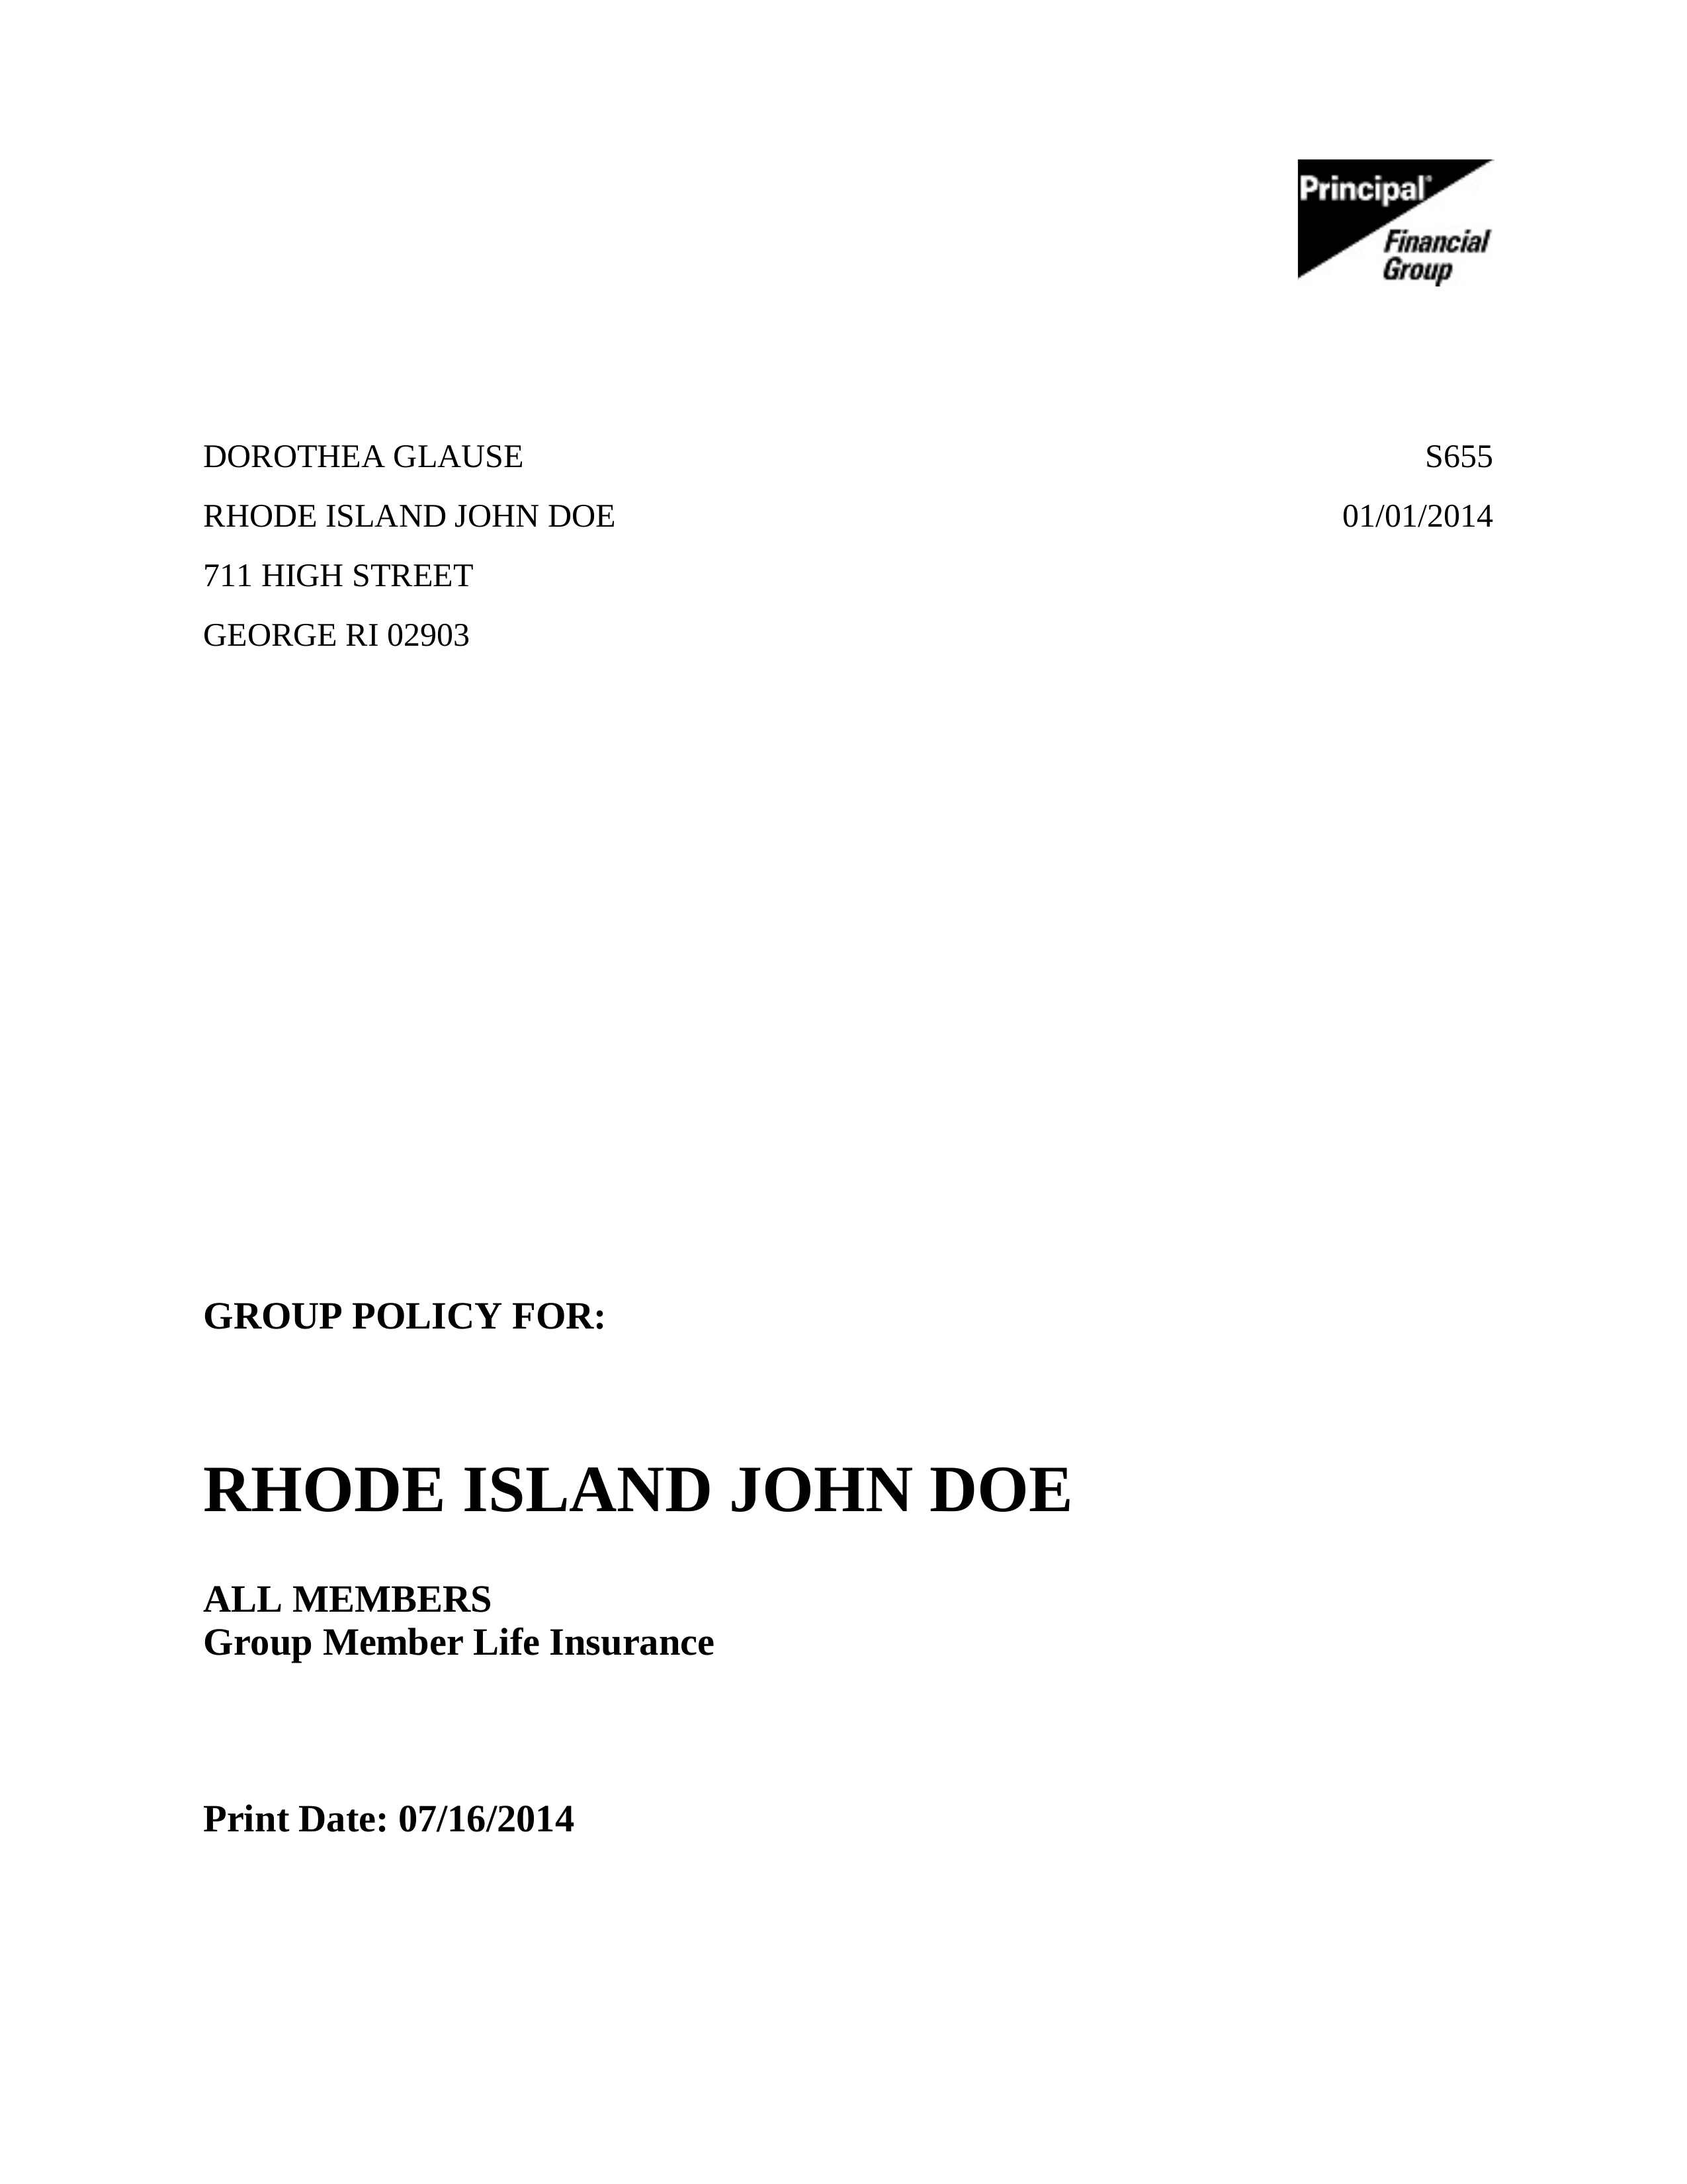

In [7]:
invoice = convert_from_path("/content/pdfs/Principal-Sample-Life-Insurance-Policy.pdf", dpi=300)
invoice[0]

In [13]:
!rm -rf "db"

In [14]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

64

In [15]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

load INSTRUCTOR_Transformer
max_seq_length  512


In [16]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

145

In [17]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 6.08 s, sys: 100 ms, total: 6.18 s
Wall time: 7.41 s


# Llama 2 13B

In [18]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <>
{system_prompt}
<>

{prompt} [/INST]
""".strip()

In [20]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [21]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

In [22]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [23]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [24]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [25]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

# Chat with PDF

In [28]:
result = qa_chain("which diseases are mentioned?")

 Based on the provided text, the following diseases are mentioned:

a. Injury
b. Accident
c. Congenital defect
d. Sickness

These are all listed as potential causes of "Terminally Ill" status, which is required for accelerated benefits. However, it's important to note that the text does not mention specific diseases, only general categories of conditions.


In [30]:
result = qa_chain("what is the date of issue of the group policy?")

 Based on the information provided, I can see that the group policy was issued on January 1, 2014. This is stated in the text as "This policy has been updated effective January 1, 2014."


In [31]:
result = qa_chain("who can be dependent on the policy?")

 Based on the given context, I can answer the question.

According to the text, the following individuals can be dependents on the policy:

* Spouses (referenced as "Dependents" throughout the text)

The text specifies that spouses are eligible for coverage under the group life insurance policy, provided they meet certain requirements, such as maintaining a minimum participation rate and meeting deadlines for applying for coverage. However, there is no mention of children or other relatives being eligible for dependency status. Therefore, only spouses can be considered dependents on the policy.


In [34]:
result = qa_chain("individual eligibility requirements for member life insurance and accidental death and dismemberment insurance? ")

 Based on the provided context, here are the individual eligibility requirements for Member Life Insurance and Accidental Death and Dismemberment Insurance:

1. Member Life Insurance:
	* The member must be currently insured for Member Life Insurance.
	* No changes can be made to the scheduled benefit without evidence of insurability.
2. Accidental Death and Dismemberment Insurance:
	* The member must be insured for Member Life Insurance.
	* The injury must be caused by external, violent, and accidental means.
	* The loss must occur within 365 days of the injury.

Note that there are additional requirements and limitations specified in the context, such as the age percentages for the Scheduled Benefit and the exclusions and limitations outlined in Article 9. However, these are the main individual eligibility requirements for Member Life Insurance and Accidental Death and Dismemberment Insurance based on the provided context.
